### OpenCV DNN을 이용하여 SSD 기반 Object Detection 수행
* Tensorflow 에서 Pretrained 된 모델 파일을 OpenCV에서 로드하여 이미지와 영상에 대한 Object Detection 수행.
* SSD+Inception과 SSD+MobileNet v3 를 모두 테스트
* CPU기반 환경에서 SSD의 Inference 속도 주시.

#### 입력 이미지로 사용될 이미지 다운로드


In [2]:
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2023-06-15 13:31:43--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.04s   

2023-06-15 13:31:44 (8.22 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



#### Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
* pretrained 모델은 http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz 에서 다운로드 후 압축 해제
* pretrained 모델을 위한 환경 파일은 https://github.com/opencv/opencv_extra/blob/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt 에서 다운로드
* download된 모델 파일과 config 파일을 인자로 하여 inference 모델을 DNN에서 로딩함.


In [3]:
!mkdir ./pretrained

!wget -O ./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
!wget -O ./pretrained/ssd_config_01.pbtxt  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt

!tar -xvf ./pretrained/ssd_inception*.tar.gz -C ./pretrained

--2023-06-15 13:31:47--  http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.13.128, 2607:f8b0:400c:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.13.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278126337 (265M) [application/x-tar]
Saving to: ‘./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz’

./pretrained/ssd_in 100%[===================>] 265.24M   141MB/s    in 1.9s    

2023-06-15 13:31:49 (141 MB/s) - ‘./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz’ saved [278126337/278126337]

--2023-06-15 13:31:49--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.c

In [4]:
!pwd
!ls -lia ./pretrained/ssd_inception*

/content
131180 -rw-r--r-- 1 root   root 278126337 Nov 18  2017 ./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz

./pretrained/ssd_inception_v2_coco_2017_11_17:
total 201124
131182 drwxr-x--- 3 275875 5000      4096 Nov 18  2017 .
131179 drwxr-xr-x 3 root   root      4096 Jun 15 13:31 ..
131190 -rw-r----- 1 275875 5000        77 Nov 18  2017 checkpoint
131185 -rw-r----- 1 275875 5000 101987441 Nov 18  2017 frozen_inference_graph.pb
131186 -rw-r----- 1 275875 5000 100214372 Nov 18  2017 model.ckpt.data-00000-of-00001
131183 -rw-r----- 1 275875 5000     18073 Nov 18  2017 model.ckpt.index
131184 -rw-r----- 1 275875 5000   3701354 Nov 18  2017 model.ckpt.meta
131187 drwxr-x--- 3 275875 5000      4096 Nov 18  2017 saved_model


#### dnn에서 readNetFromTensorflow()로 tensorflow inference 모델을 로딩

In [5]:
import cv2

cv_net = cv2.dnn.readNetFromTensorflow('/content/pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb',
                                      '/content/pretrained/ssd_config_01.pbtxt')

#### coco 데이터 세트의 클래스id별 클래스명 지정.

In [6]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}


#### 이미지를 preprocessing 수행하여 Network에 입력하고 Object Detection 수행 후 결과를 이미지에 시각화

(1, 1, 100, 7)
person: 0.9696 1
person: 0.9660 1
person: 0.8916 1
car: 0.8609 3
car: 0.7223 3
car: 0.7184 3
car: 0.7095 3
person: 0.6298 1
car: 0.5949 3
car: 0.5511 3


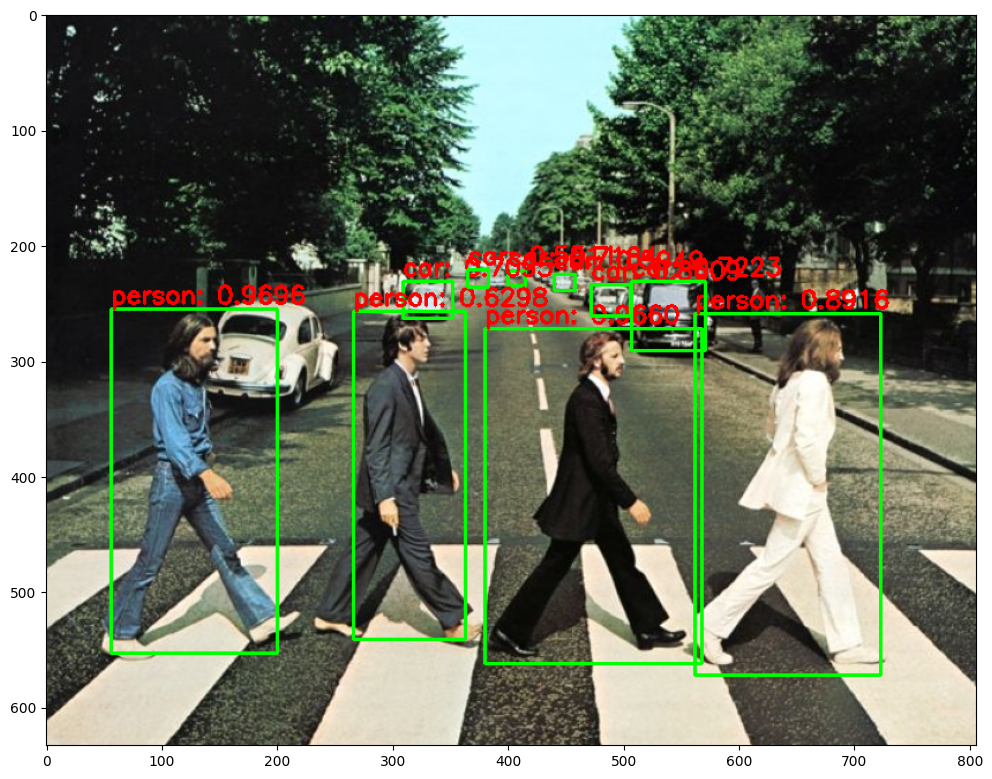

In [7]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('/content/data/beatles01.jpg')

# 원본 이미지 (633, 806)를 네트웍에 입력시에는 (300, 300)로 resize 함.
# 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0]
cols = img.shape[1]
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성.
draw_img = img.copy()

# 원본 이미지 배열을 사이즈 (300, 300)으로, BGR을 RGB로 변환하여 배열 입력
cv_net.setInput(cv2.dnn.blobFromImage(img,  size=(300, 300), swapRB=True, crop=False))
# Object Detection 수행하여 결과를 cv_out으로 반환
cv_out = cv_net.forward()
print(cv_out.shape)

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# detected 된 object들을 iteration 하면서 정보 추출
for detection in cv_out[0,0,:,:]:
    score = float(detection[2])
    class_id = int(detection[1])
    # detected된 object들의 score가 0.4 이상만 추출
    if score > 0.4:
        # detected된 object들은 image 크기가 (300, 300)으로 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
        # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
        caption = "{}: {:.4f}".format(labels_to_names[class_id], score)

        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 2)
        print(caption, class_id)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### 단일 이미지의 object detection을 함수로 생성

In [8]:
import time

def get_detected_img(cv_net, img_array, score_threshold, is_print=True):

    rows = img_array.shape[0]
    cols = img_array.shape[1]

    draw_img = img_array.copy()

    cv_net.setInput(cv2.dnn.blobFromImage(img_array, size=(300, 300), swapRB=True, crop=False))

    start = time.time()
    cv_out = cv_net.forward()

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    # detected 된 object들을 iteration 하면서 정보 추출
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])
        # detected된 object들의 score가 0.4 이상만 추출
        if score > score_threshold:
            # detected된 object들은 image 크기가 (300, 300)으로 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names[class_id], score)

            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 2)
    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")

    return draw_img

Detection 수행시간: 0.18 초


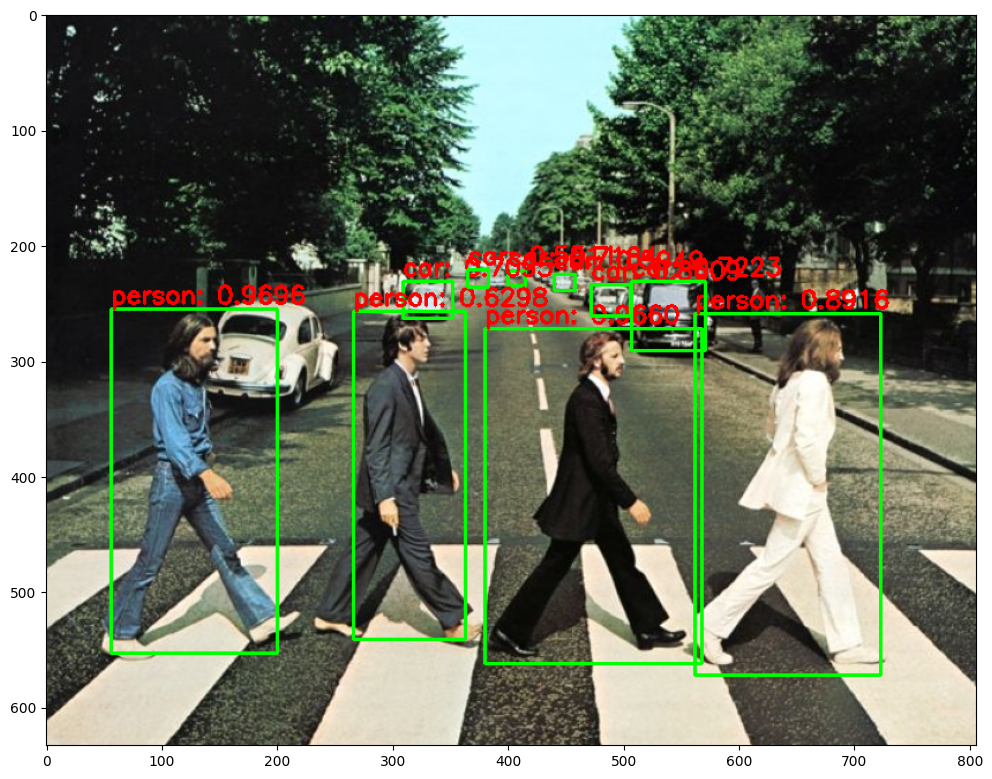

In [9]:
# image 로드
img = cv2.imread('/content/data/beatles01.jpg')

#coco dataset 클래스명 매핑

# Object Detetion 수행 후 시각화
draw_img = get_detected_img(cv_net, img, score_threshold=0.4, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

--2023-06-15 13:32:26--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76279 (74K) [image/jpeg]
Saving to: ‘./data/baseball01.jpg’

./data/baseball01.j 100%[===================>]  74.49K  --.-KB/s    in 0.02s   

2023-06-15 13:32:26 (4.25 MB/s) - ‘./data/baseball01.jpg’ saved [76279/76279]

Detection 수행시간: 0.22 초


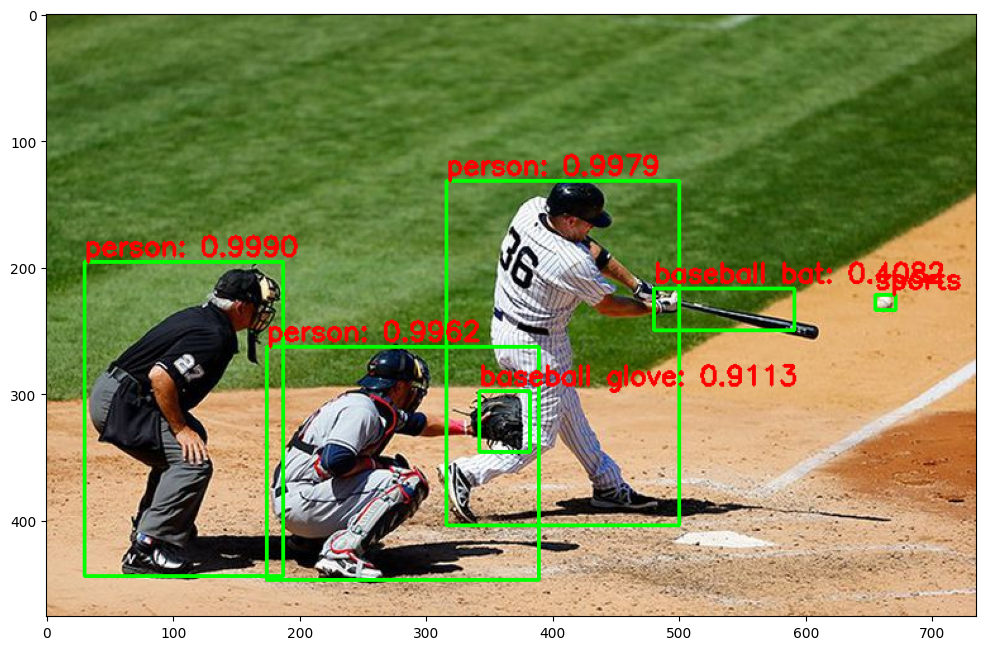

In [10]:
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

img = cv2.imread('/content/data/baseball01.jpg')

#coco dataset 클래스명 매핑

# Object Detetion 수행 후 시각화
draw_img = get_detected_img(cv_net, img, score_threshold=0.4, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

### Video Object Detection 수행

In [11]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2023-06-15 13:32:37--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2023-06-15 13:32:37--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2023-06-15 13:32:38--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.

#### VideoCapture와 VideoWriter 설정하고 Video Detection용 전용 함수 생성
* VideoCapture를 이용하여 Video를 frame별로 capture 할 수 있도록 설정
* VideoCapture의 속성을 이용하여 Video Frame의 크기 및 FPS 설정.
* VideoWriter를 위한 인코딩 코덱 설정 및 영상 write를 위한 설정
총 Frame 별로 iteration 하면서 Object Detection 수행. 개별 frame별로 단일 이미지 Object Detection과 유사

In [12]:
def do_detected_video(cv_net, input_path, output_path, score_threshold, is_print):

    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, )

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break

        returned_frame = get_detected_img(cv_net, img_frame, score_threshold=score_threshold, is_print=True)
        vid_writer.write(returned_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [13]:
do_detected_video(cv_net, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_incept.mp4', 0.2, False)

총 Frame 갯수: 58
Detection 수행시간: 0.33 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.32 초
Detection 수행시간: 0.28 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.21 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.21 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.21 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.2 초
Detection 수행

### SSD+Mobilenet v3 Object Detection 수행.
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
* weight파일은 http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz 에서 다운로드
* SSD + Mobilenet v3 backbone은 opencv dnn 모듈이 아니라 dnn_DetectionModel() 함수로 생성 가능하며, 이를 사용하기 위해서는 Opencv의 버전을 Upgrade해야함.

In [14]:
!mkdir ./pretrained
!wget -O ./pretrained/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz
!wget -O ./pretrained/ssd_config_02.pbtxt https://gist.githubusercontent.com/dkurt/54a8e8b51beb3bd3f770b79e56927bd7/raw/2a20064a9d33b893dd95d2567da126d0ecd03e85/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt

!!tar -xvf ./pretrained/ssd_mobilenet*.tar.gz -C ./pretrained

mkdir: cannot create directory ‘./pretrained’: File exists
--2023-06-15 13:41:05--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.13.128, 2607:f8b0:400c:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.13.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49318766 (47M) [application/gzip]
Saving to: ‘./pretrained/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz’

./pretrained/ssd_mo 100%[===================>]  47.03M  73.7MB/s    in 0.6s    

2023-06-15 13:41:06 (73.7 MB/s) - ‘./pretrained/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz’ saved [49318766/49318766]

--2023-06-15 13:41:06--  https://gist.githubusercontent.com/dkurt/54a8e8b51beb3bd3f770b79e56927bd7/raw/2a20064a9d33b893dd95d2567da126d0ecd03e85/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt
Resolving gist.githubusercontent.com (gist.githubusercontent.c

['ssd_mobilenet_v3_large_coco_2020_01_14/pipeline.config',
 'ssd_mobilenet_v3_large_coco_2020_01_14/model.ckpt.index',
 'ssd_mobilenet_v3_large_coco_2020_01_14/model.ckpt.data-00000-of-00001',
 'ssd_mobilenet_v3_large_coco_2020_01_14/model.tflite',
 'ssd_mobilenet_v3_large_coco_2020_01_14/frozen_inference_graph.pb',
 'ssd_mobilenet_v3_large_coco_2020_01_14/checkpoint',
 'ssd_mobilenet_v3_large_coco_2020_01_14/model.ckpt.meta',
 'ssd_mobilenet_v3_large_coco_2020_01_14/']

In [3]:
print(cv2.__version__)

4.7.0


### opencv의 버전을 Upgrade한 후 dnn_DetectionModel() 사용.
* https://github.com/opencv/opencv/pull/16760
* dnn_DetectionModel()은 dnn_Model 객체 반환
* 해당 SSD 모델은 image pixel값을 -1 ~ 1 사이로 정규화하고 image size는 320, 320으로 설정.


In [15]:
!pip install opencv-python==4.5.2.54

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement opencv-python==4.5.2.54 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72)
ERROR: No matching distribution found for opencv-python==4.5.2.54


In [2]:
import cv2

cv_net_m = cv2.dnn_DetectionModel('/content/pretrained/ssd_mobilenet_v3_large_coco_2020_01_14/frozen_inference_graph.pb',
                                      '/content/pretrained/ssd_config_02.pbtxt')
cv_net_m.setInputSize(320, 320)  #이미지 사이즈 고정해줘야함
cv_net_m.setInputScale(1.0 / 127.5)
cv_net_m.setInputMean((127.5, 127.5, 127.5))
cv_net_m.setInputSwapRB(True)

< cv2.dnn.Model 0x7feaa0419db0>

### dnn_Model 객체의 detect() 메소드는 입력 이미지를 받아서 특정 confidence threshold 이상의 모든 object inference 결과를 반환.
* class id값, confidence score값, bbox 좌표값이 arrary로 반환됨.
* bbox 좌표값의 경우 0~1사이 값이 아니라 정수형의 위치값이 반환됨. 단 xmin, ymin, width, height 형태로 반환되므로 유의 필요.

In [ ]:
img = cv2.imread('/content/data/beatles01.jpg')
draw_img = img.copy()

classes, confidences, boxes = cv_net_m.detect(img, confThreshold=0.5)

In [ ]:
classes, confidences, boxes

In [ ]:
classes.shape, confidences.shape, boxes.shape

In [ ]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [ ]:
import matplotlib.pyplot as plt

green_color=(0, 255, 0)
red_color=(0, 0, 255)

for class_id, confidence_score, box in zip(classes.flatten(), confidences.flatten(), boxes):
    if confidence_score > 0.5:
      caption = "{}: {:.4f}".format(labels_to_names[class_id], confidence_score)
      # box 반환 좌표값은 정수형 위치 좌표임. xmin, ymin, width, height임에 유의
      cv2.rectangle(draw_img, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), color=green_color, thickness=2)
      cv2.putText(draw_img, caption, (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, red_color, 2)
      print(caption, class_id, box)

draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

#### 단일 이미지의 object detection을 함수로 생성

In [ ]:
import time
def get_detected_img_renew(cv_net, img_array, score_threshold, is_print=True):

  draw_img = img_array.copy()

  start = time.time()

  classes, confidences, boxes = cv_net.detect(img_array, confThreshold=0.5)

  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # detected 된 object들을 iteration 하면서 정보 추출
  for class_id, confidence_score, box in zip(classes.flatten(), confidences.flatten(), boxes):
    if confidence_score > 0.5:
      caption = "{}: {:.4f}".format(labels_to_names[class_id], confidence_score)
      cv2.rectangle(draw_img, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), color=green_color, thickness=2)
      cv2.putText(draw_img, caption, (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, red_color, 2)
      print(caption)

  if is_print:
      print('Detection 수행시간:',round(time.time() - start, 2),"초")

  return draw_img

In [ ]:
## dnn_Model을 만드는 함수 생성.
def get_cv_detection_model(pretrained_path, config_path):
  cv_net = cv2.dnn_DetectionModel(pretrained_path, config_path)
  cv_net.setInputSize(320, 320)
  cv_net.setInputScale(1.0 / 127.5)
  cv_net.setInputMean((127.5, 127.5, 127.5))
  cv_net.setInputSwapRB(True)

  return cv_net

cv_net_m = get_cv_detection_model('/content/pretrained/ssd_mobilenet_v3_large_coco_2020_01_14/frozen_inference_graph.pb',
                       '/content/pretrained/ssd_config_02.pbtxt')

In [ ]:
img = cv2.imread('./data/beatles01.jpg')

# Object Detetion 수행 후 시각화
draw_img = get_detected_img_renew(cv_net_m, img, score_threshold=0.5,  is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [ ]:
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

img = cv2.imread('./data/baseball01.jpg')

# Object Detetion 수행 후 시각화
draw_img = get_detected_img_renew(cv_net_m, img, score_threshold=0.5,  is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

### Video Inferece 수행.

In [ ]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

In [ ]:
def do_detected_video_renew(cv_net, input_path, output_path, score_threshold, is_print):

    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, )

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break

        returned_frame = get_detected_img_renew(cv_net, img_frame, score_threshold=score_threshold, is_print=True)
        vid_writer.write(returned_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [ ]:
do_detected_video_renew(cv_net_m, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_m3.mp4', 0.2, False)